In [1]:
from google.colab import files

uploaded = files.upload()

Saving test2.jsonl to test2.jsonl
Saving train2.jsonl to train2.jsonl
Saving val2.jsonl to val2.jsonl


**Importing libraries**

In [2]:
import json
import pandas as pd
import numpy as np
import os
import pickle
import spacy
import logging
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from textblob import TextBlob
from sklearn.pipeline import FeatureUnion



**Loading Data**

In [3]:
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

train_data = load_jsonl('train2.jsonl')
test_data = load_jsonl('test2.jsonl')
val_data = load_jsonl('val2.jsonl')

print("Training Data loaded", len(train_data)," records")
print("Test Data loaded ", len(test_data)," records")
print("Validation Data loaded ", len(val_data)," records")


Training Data loaded 10269  records
Test Data loaded  1283  records
Validation Data loaded  1284  records


**Normanlising labels**

In [4]:
def normalize_labels(dataframe):
    label_map = {
        "pants-fire": False,
        "barely-true": False,
        "false": False,
        "half-true": True,
        "mostly-true": True,
        "true": True
    }
    dataframe['label'] = dataframe['label'].map(label_map)
    return dataframe

train_data = normalize_labels(train_data)
test_data = normalize_labels(test_data)
val_data = normalize_labels(val_data)


In [5]:
train_data.head()

,id,json_file_id,label,claim,topics,originator,title,party,justification
0,0,2635.json,False,Says the Annies List political group supports ...,[abortion],dwayne-bohac,State representative,Texas,That's a premise that he fails to back up. Ann...
1,1,10540.json,True,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott-surovell,State delegate,Virginia,"""Surovell said the decline of coal """"started w..."
2,2,324.json,True,"""Hillary Clinton agrees with John McCain """"by ...",[foreign-policy],barack-obama,President,Illinois,"""Obama said he would have voted against the am..."
3,3,1123.json,False,Health care reform legislation is likely to ma...,[health-care],blog-posting,,,"""The release may have a point that Mikulskis c..."
4,4,9028.json,True,The economic turnaround started at the end of ...,"[economy, jobs]",charlie-crist,,Florida,"""Crist said that the economic """"turnaround sta..."


**Using TF-IDF for Text Data Representation**

In [6]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_data['claim']).toarray()
y_train = train_data['label']

X_test = vectorizer.transform(test_data['claim']).toarray()
y_test = test_data['label']

X_val = vectorizer.transform(val_data['claim']).toarray()
y_val = val_data['label']


**Model bulding with Random Forest Classifier**

In [7]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

import pickle
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model training complete.")


Model training complete.


In [8]:
def evaluate_model(model, X, y, dataset_name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, output_dict=True)
    return accuracy, report
test_accuracy, test_report = evaluate_model(model, X_test, y_test, "Test Data")
val_accuracy, val_report = evaluate_model(model, X_val, y_val, "Validation Data")
print("\n=== Evaluation Results ===")
print(f"Test Data Accuracy: {test_accuracy:.4f}")
print("\nTest Data Classification Report:")
print(pd.DataFrame(test_report).T)

print(f"\nValidation Data Accuracy: {val_accuracy:.4f}")
print("\nValidation Data Classification Report:")
print(pd.DataFrame(val_report).T)



=== Evaluation Results ===
Test Data Accuracy: 0.6118

Test Data Classification Report:
              precision    recall  f1-score      support
False          0.570388  0.422662  0.485537   556.000000
True           0.631458  0.756534  0.688360   727.000000
accuracy       0.611847  0.611847  0.611847     0.611847
macro avg      0.600923  0.589598  0.586949  1283.000000
weighted avg   0.604993  0.611847  0.600465  1283.000000

Validation Data Accuracy: 0.6246

Validation Data Classification Report:
              precision    recall  f1-score      support
False          0.662621  0.443182  0.531128   616.000000
True           0.606651  0.791916  0.687013   668.000000
accuracy       0.624611  0.624611  0.624611     0.624611
macro avg      0.634636  0.617549  0.609071  1284.000000
weighted avg   0.633503  0.624611  0.612227  1284.000000


**Predicting truthfulness of a sentence**

In [9]:
def predict_truthfulness(sentence):
    sentence_df = pd.DataFrame({'claim': [sentence]})

    # Transform the sentence into the same feature space as the training data
    X_input = vectorizer.transform(sentence_df['claim']).toarray()
    prediction = model.predict(X_input)
    label_map = {
        False: "False",
        True: "True"
    }

    return label_map[prediction[0]]

In [10]:
input_sentence = "The economic turnaround started at the end of my term."
result = predict_truthfulness(input_sentence)
print(f"The model predicts that the statement is: {result}")

The model predicts that the statement is: True


**Model building with Gradient boosting**




In [11]:

model_gb = GradientBoostingClassifier(random_state=42)
model_gb.fit(X_train, y_train)

with open('gradient_boosting_model.pkl', 'wb') as f:
    pickle.dump(model_gb, f)

print("Gradient Boosting model training complete.")


NameError: name 'GradientBoostingClassifier' is not defined

In [ ]:
def evaluate_model(model_gb, X, y, dataset_name):
    y_pred = model_gb.predict(X)
    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, output_dict=True)
    return accuracy, report
test_accuracy, test_report = evaluate_model(model_gb, X_test, y_test, "Test Data")
val_accuracy, val_report = evaluate_model(model_gb, X_val, y_val, "Validation Data")

# Print Results
print("\n=== Evaluation Results ===")
print(f"Test Data Accuracy: {test_accuracy:.4f}")
print("\nTest Data Classification Report:")
print(pd.DataFrame(test_report).T)

print(f"\nValidation Data Accuracy: {val_accuracy:.4f}")
print("\nValidation Data Classification Report:")
print(pd.DataFrame(val_report).T)



=== Evaluation Results ===
Test Data Accuracy: 0.6072

Test Data Classification Report:
              precision    recall  f1-score      support
False          0.601562  0.276978  0.379310   556.000000
True           0.608569  0.859697  0.712657   727.000000
accuracy       0.607171  0.607171  0.607171     0.607171
macro avg      0.605066  0.568338  0.545984  1283.000000
weighted avg   0.605532  0.607171  0.568198  1283.000000

Validation Data Accuracy: 0.5966

Validation Data Classification Report:
              precision    recall  f1-score      support
False          0.677536  0.303571  0.419283   616.000000
True           0.574405  0.866766  0.690931   668.000000
accuracy       0.596573  0.596573  0.596573     0.596573
macro avg      0.625970  0.585169  0.555107  1284.000000
weighted avg   0.623882  0.596573  0.560607  1284.000000


**Model building with Passive Aggresie Model**

In [12]:
# Training the Passive Aggressive model
from sklearn.linear_model import PassiveAggressiveClassifier
model_pa = PassiveAggressiveClassifier(random_state=42)
model_pa.fit(X_train, y_train)

# save the model
with open('passive_aggressive_model.pkl', 'wb') as f:
    pickle.dump(model_pa, f)

print("Passive Aggressive model training complete.")


Passive Aggressive model training complete.


In [13]:
def evaluate_model(model_pa, X, y, dataset_name):
    y_pred = model_pa.predict(X)
    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, output_dict=True)
    return accuracy, report
test_accuracy, test_report = evaluate_model(model_pa, X_test, y_test, "Test Data")
val_accuracy, val_report = evaluate_model(model_pa, X_val, y_val, "Validation Data")

print("\n=== Evaluation Results ===")
print(f"Test Data Accuracy: {test_accuracy:.4f}")
print("\nTest Data Classification Report:")
print(pd.DataFrame(test_report).T)

print(f"\nValidation Data Accuracy: {val_accuracy:.4f}")
print("\nValidation Data Classification Report:")
print(pd.DataFrame(val_report).T)



=== Evaluation Results ===
Test Data Accuracy: 0.6048

Test Data Classification Report:
              precision    recall  f1-score      support
False          0.551363  0.473022  0.509197   556.000000
True           0.636476  0.705640  0.669276   727.000000
accuracy       0.604832  0.604832  0.604832     0.604832
macro avg      0.593920  0.589331  0.589236  1283.000000
weighted avg   0.599592  0.604832  0.599904  1283.000000

Validation Data Accuracy: 0.5615

Validation Data Classification Report:
              precision    recall  f1-score      support
False          0.553320  0.446429  0.494160   616.000000
True           0.566709  0.667665  0.613058   668.000000
accuracy       0.561526  0.561526  0.561526     0.561526
macro avg      0.560014  0.557047  0.553609  1284.000000
weighted avg   0.560286  0.561526  0.556017  1284.000000


****Model building with XGBoost model****

In [14]:
import xgboost as xgb
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model_xgb.fit(X_train, y_train)
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(model_xgb, f)

print("XGBoost model training complete.")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:37:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost model training complete.


In [15]:
def evaluate_model(model_xgb, X, y, dataset_name):
    y_pred = model_xgb.predict(X)
    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, output_dict=True)
    return accuracy, report
test_accuracy, test_report = evaluate_model(model_xgb, X_test, y_test, "Test Data")
val_accuracy, val_report = evaluate_model(model_xgb, X_val, y_val, "Validation Data")
print("\n=== Evaluation Results ===")
print(f"Test Data Accuracy: {test_accuracy:.4f}")
print("\nTest Data Classification Report:")
print(pd.DataFrame(test_report).T)

print(f"\nValidation Data Accuracy: {val_accuracy:.4f}")
print("\nValidation Data Classification Report:")
print(pd.DataFrame(val_report).T)



=== Evaluation Results ===
Test Data Accuracy: 0.6048

Test Data Classification Report:
              precision    recall  f1-score      support
False          0.558473  0.420863  0.480000   556.000000
True           0.627315  0.745530  0.681332   727.000000
accuracy       0.604832  0.604832  0.604832     0.604832
macro avg      0.592894  0.583196  0.580666  1283.000000
weighted avg   0.597481  0.604832  0.594083  1283.000000

Validation Data Accuracy: 0.6316

Validation Data Classification Report:
              precision    recall  f1-score     support
False          0.653105  0.495130  0.563250   616.00000
True           0.619339  0.757485  0.681481   668.00000
accuracy       0.631620  0.631620  0.631620     0.63162
macro avg      0.636222  0.626307  0.622366  1284.00000
weighted avg   0.635538  0.631620  0.624760  1284.00000



=== Model Comparison Results ===
                Model          Dataset  Accuracy  Precision    Recall  \
0       Random Forest        Test Data  0.611847   0.604993  0.611847   
1       Random Forest  Validation Data  0.624611   0.633503  0.624611   
2  Passive Aggressive        Test Data  0.604832   0.599592  0.604832   
3  Passive Aggressive  Validation Data  0.561526   0.560286  0.561526   
4             XGBoost        Test Data  0.604832   0.597481  0.604832   
5             XGBoost  Validation Data  0.631620   0.635538  0.631620   

   F1-Score  
0  0.600465  
1  0.612227  
2  0.599904  
3  0.556017  
4  0.594083  
5  0.624760  


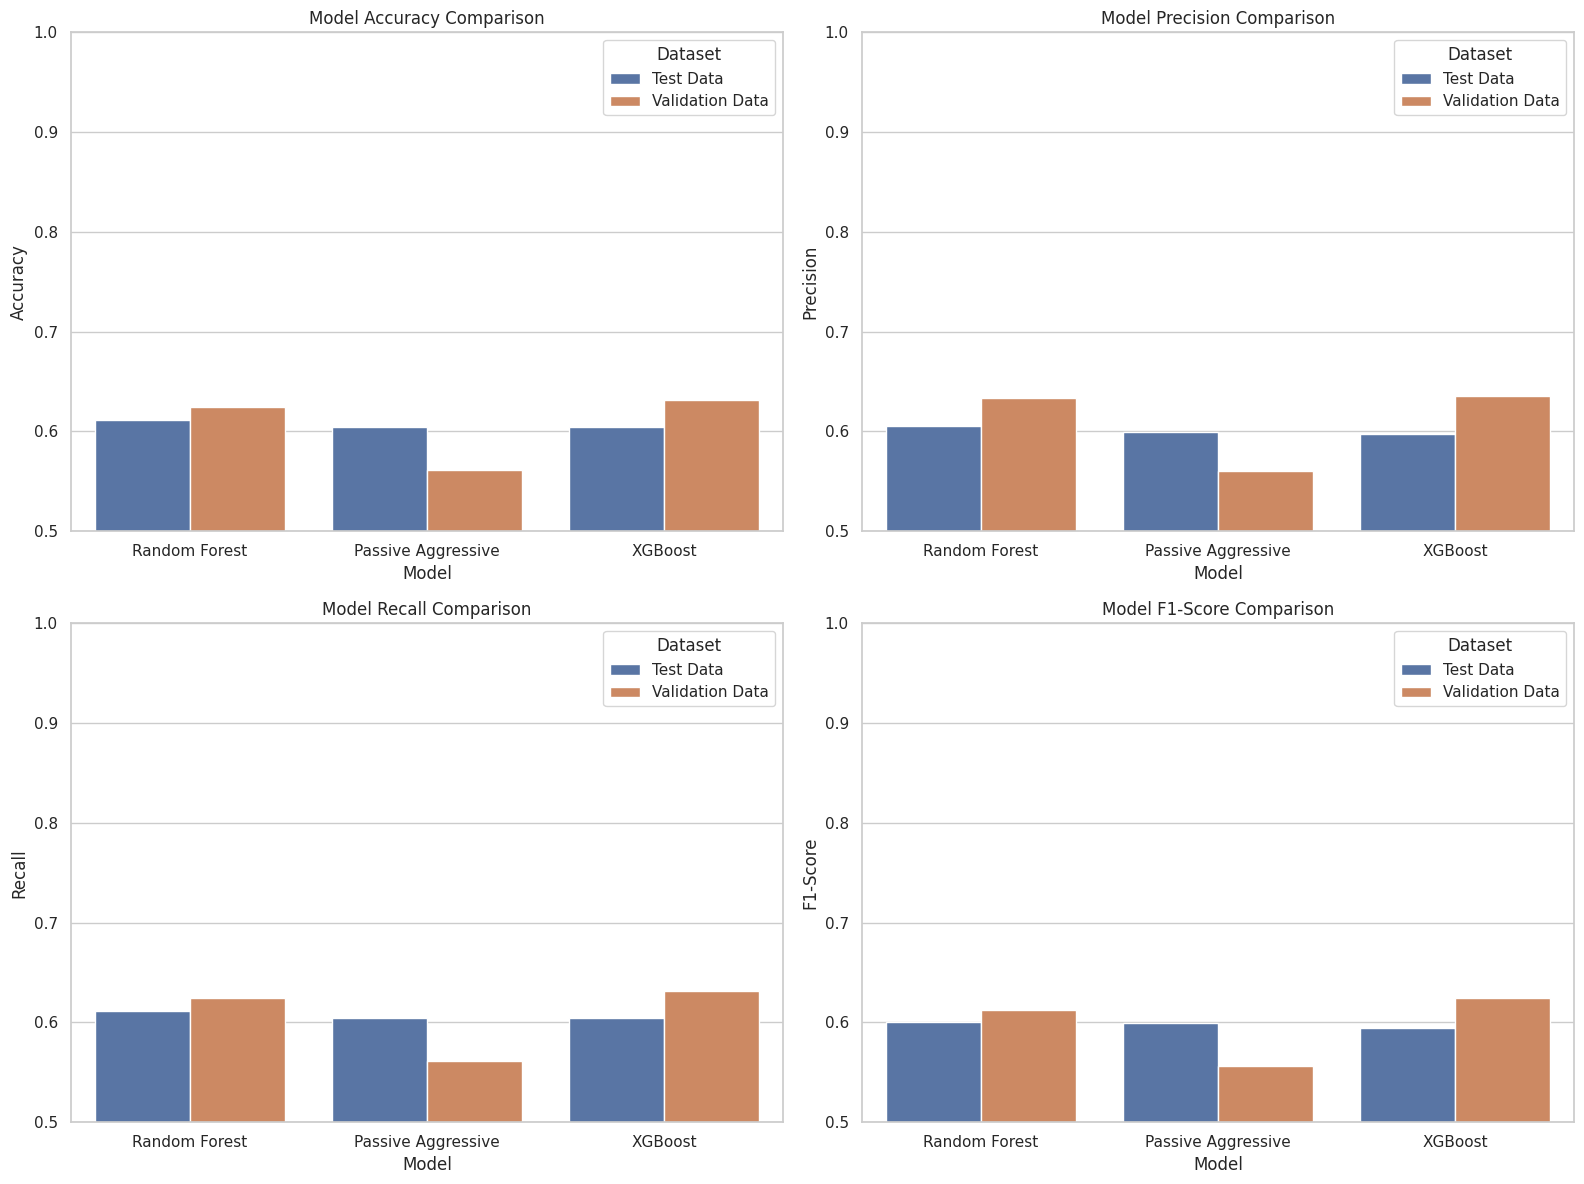

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Function to evaluate a model and return performance metrics
def evaluate_model(model, X, y, dataset_name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, output_dict=True)
    return accuracy, pd.DataFrame(report).T

# Evaluate all models on Test and Validation datasets
models = {
    "Random Forest": model,
    "Passive Aggressive": model_pa,
    "XGBoost": model_xgb
}

results = {
    "Model": [],
    "Dataset": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

for model_name, model in models.items():
    for dataset_name, (X, y) in {
        "Test Data": (X_test, y_test),
        "Validation Data": (X_val, y_val)
    }.items():
        accuracy, report = evaluate_model(model, X, y, dataset_name)
        results["Model"].append(model_name)
        results["Dataset"].append(dataset_name)
        results["Accuracy"].append(accuracy)
        results["Precision"].append(report.loc["weighted avg", "precision"])
        results["Recall"].append(report.loc["weighted avg", "recall"])
        results["F1-Score"].append(report.loc["weighted avg", "f1-score"])

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results as a table
print("\n=== Model Comparison Results ===")
print(results_df)

# Plot the results
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy comparison
sns.barplot(data=results_df, x="Model", y="Accuracy", hue="Dataset", ax=axes[0, 0])
axes[0, 0].set_title("Model Accuracy Comparison")
axes[0, 0].set_ylim(0.5, 1)

# Precision comparison
sns.barplot(data=results_df, x="Model", y="Precision", hue="Dataset", ax=axes[0, 1])
axes[0, 1].set_title("Model Precision Comparison")
axes[0, 1].set_ylim(0.5, 1)

# Recall comparison
sns.barplot(data=results_df, x="Model", y="Recall", hue="Dataset", ax=axes[1, 0])
axes[1, 0].set_title("Model Recall Comparison")
axes[1, 0].set_ylim(0.5, 1)

# F1-Score comparison
sns.barplot(data=results_df, x="Model", y="F1-Score", hue="Dataset", ax=axes[1, 1])
axes[1, 1].set_title("Model F1-Score Comparison")
axes[1, 1].set_ylim(0.5, 1)

# Adjust layout
plt.tight_layout()
plt.show()


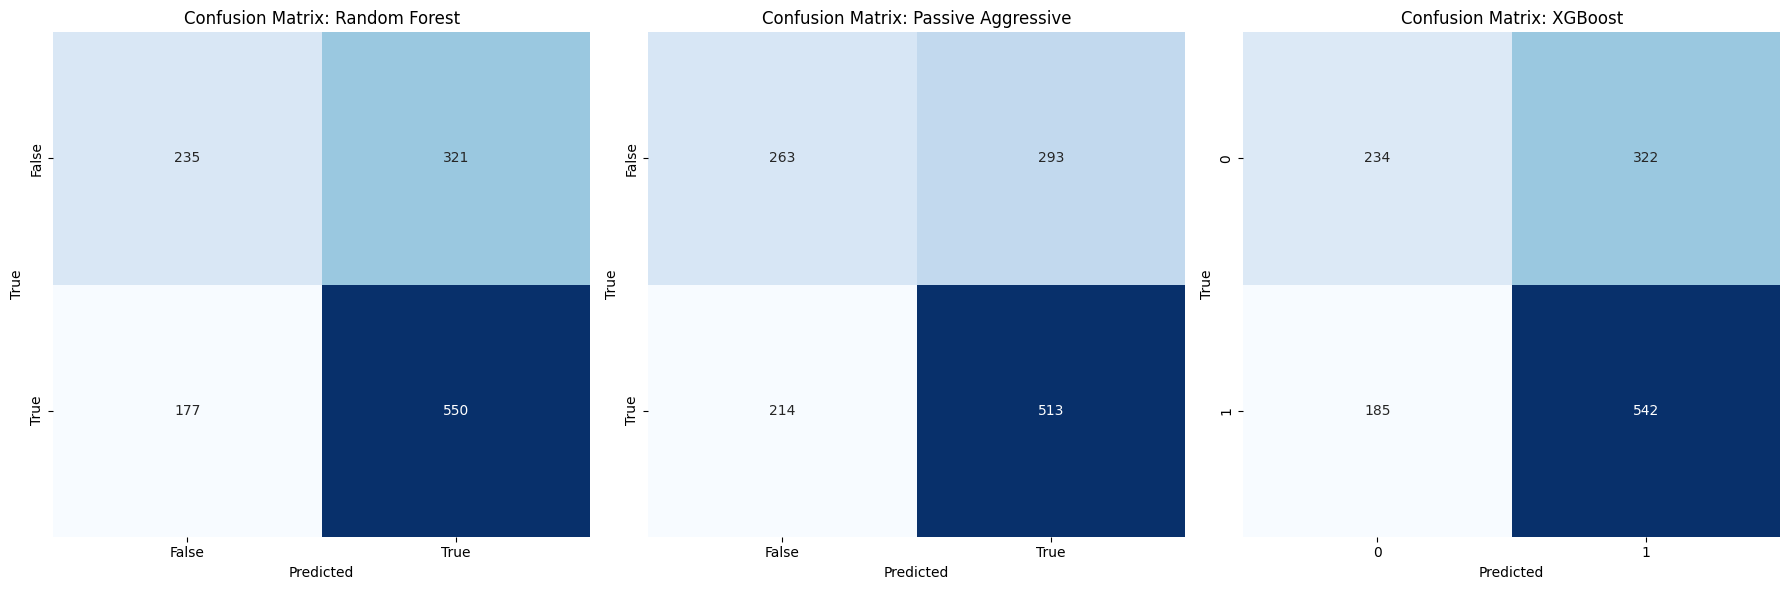

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# List of models to evaluate
models = {
    "Random Forest": model,
    "Passive Aggressive": model_pa,
    "XGBoost": model_xgb
}

# Create a figure for the confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through each model and plot the confusion matrix
for i, (model_name, model) in enumerate(models.items()):
    # Predict on the test data
    y_pred = model.predict(X_test)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix as heatmap
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[i],
                cbar=False, xticklabels=model.classes_, yticklabels=model.classes_)
    axes[i].set_title(f"Confusion Matrix: {model_name}")
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

# Adjust layout
plt.tight_layout()
plt.show()


**Including Entity Recognition,Sentiment Analysis,POS tagging**

In [ ]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Custom Transformer for NER
class NERExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [[ent.label_ for ent in nlp(text).ents] for text in X]

In [ ]:
# Custom Transformer for Sentiment Analysis
class SentimentExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [[TextBlob(text).sentiment.polarity] for text in X]

In [ ]:
# Create a DataFrame to hold the additional features
train_data['sentiment'] = [TextBlob(claim).sentiment.polarity for claim in train_data['claim']]
train_data['ner'] = [len(nlp(claim).ents) for claim in train_data['claim']]
test_data['sentiment'] = [TextBlob(claim).sentiment.polarity for claim in test_data['claim']]
test_data['ner'] = [len(nlp(claim).ents) for claim in test_data['claim']]
val_data['sentiment'] = [TextBlob(claim).sentiment.polarity for claim in val_data['claim']]
val_data['ner'] = [len(nlp(claim).ents) for claim in val_data['claim']]

In [ ]:
# Train features and labels
X_train = pd.concat([pd.DataFrame(X_train), train_data[['sentiment', 'ner']]], axis=1)
y_train = train_data['label']

X_test = pd.concat([pd.DataFrame(X_test), test_data[['sentiment', 'ner']]], axis=1)
y_test = test_data['label']

X_val = pd.concat([pd.DataFrame(X_val), val_data[['sentiment', 'ner']]], axis=1)
y_val = val_data['label']

In [ ]:
# Modify DataFrame to hold the additional features
train_data['sentiment'] = [TextBlob(claim).sentiment.polarity for claim in train_data['claim']]
train_data['ner'] = [len(nlp(claim).ents) for claim in train_data['claim']]
test_data['sentiment'] = [TextBlob(claim).sentiment.polarity for claim in test_data['claim']]
test_data['ner'] = [len(nlp(claim).ents) for claim in test_data['claim']]
val_data['sentiment'] = [TextBlob(claim).sentiment.polarity for claim in val_data['claim']]
val_data['ner'] = [len(nlp(claim).ents) for claim in val_data['claim']]

In [ ]:
# Train features and labels
X_train = pd.concat([pd.DataFrame(X_train), train_data[['sentiment', 'ner']]], axis=1)
y_train = train_data['label']

X_test = pd.concat([pd.DataFrame(X_test), test_data[['sentiment', 'ner']]], axis=1)
y_test = test_data['label']

X_val = pd.concat([pd.DataFrame(X_val), val_data[['sentiment', 'ner']]], axis=1)
y_val = val_data['label']

In [ ]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)
X_val = X_val.astype(float)

In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)
X_val.columns = X_val.columns.astype(str)

In [ ]:

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Optionally save the model
with open('random_forest_model_with_nlp.pkl', 'wb') as f:
    pickle.dump(model, f)


In [ ]:
def evaluate_model(model, X, y, dataset_name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, output_dict=True)  # Get the report as a dictionary
    return accuracy, report
# Evaluate the model on test and validation data
test_accuracy, test_report = evaluate_model(model, X_test, y_test, "Test Data")
val_accuracy, val_report = evaluate_model(model, X_val, y_val, "Validation Data")

# Print Results
print("\n=== Evaluation Results ===")
print(f"Test Data Accuracy: {test_accuracy:.4f}")
print("\nTest Data Classification Report:")
print(pd.DataFrame(test_report).T)

print(f"\nValidation Data Accuracy: {val_accuracy:.4f}")
print("\nValidation Data Classification Report:")
print(pd.DataFrame(val_report).T)



=== Evaluation Results ===
Test Data Accuracy: 0.2471

Test Data Classification Report:
              precision    recall  f1-score      support
0              0.252747  0.107477  0.150820   214.000000
1              0.261959  0.460000  0.333817   250.000000
2              0.236842  0.303371  0.266010   267.000000
3              0.226804  0.265060  0.244444   249.000000
4              0.571429  0.043478  0.080808    92.000000
5              0.247788  0.132701  0.172840   211.000000
accuracy       0.247077  0.247077  0.247077     0.247077
macro avg      0.299595  0.218681  0.208123  1283.000000
weighted avg   0.268233  0.247077  0.227221  1283.000000

Validation Data Accuracy: 0.2484

Validation Data Classification Report:
              precision    recall  f1-score      support
0              0.242857  0.143460  0.180371   237.000000
1              0.263852  0.380228  0.311526   263.000000
2              0.248538  0.342742  0.288136   248.000000
3              0.241497  0.282869  0.26